In [10]:
import torch
import tiktoken

from codes.gpt_model import GPTModel
from codes.data import create_dataloader_v1
from codes.losses import calc_loss_batch, calc_loss_loader
from codes.utils import (
    generate_text_simple, 
    text_to_token_ids,
    token_ids_to_text
)

In [7]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [8]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded, 
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

In [17]:
def train_model_simple(
    model, 
    train_loader, 
    val_loader, 
    optimizer, 
    device, 
    num_epochs, 
    eval_freq, 
    eval_iter,
    start_context,
    tokenizer
):
    train_losses, val_losses, track_tokens_seen = [], [], []
    token_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            loss.backward()
            optimizer.step()

            token_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)

                track_tokens_seen.append(token_seen)

                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f} "
                      f"Val loss {val_loss:.3f}"
                )
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

In [18]:
def build_dataloader():
    with open("the-verdict.txt", "r", encoding="utf-8") as fin:
        raw_data = fin.read()

    train_ratio = 0.9
    split_idx = int(train_ratio * len(raw_data))
    train_data = raw_data[:split_idx]
    val_data = raw_data[split_idx:]

    train_loader = create_dataloader_v1(
        train_data,
        batch_size=2,
        max_length=GPT_CONFIG_124M['context_length'],
        stride=GPT_CONFIG_124M['context_length'],
        drop_last=True
    )

    val_loader = create_dataloader_v1(
        val_data,
        batch_size=2,
        max_length=GPT_CONFIG_124M['context_length'],
        stride=GPT_CONFIG_124M['context_length'],
        drop_last=False,
        shuffle=False
    )
    return train_loader, val_loader

In [19]:
torch.manual_seed(123)
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "num_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

device = torch.device("cpu")
model = GPTModel(GPT_CONFIG_124M)
model.to(device)

train_loader, val_loader = build_dataloader()

optimizer = torch.optim.AdamW(model.parameters(), 
                              lr=4e-4, weight_decay=0.1)

tokenizer = tiktoken.get_encoding("gpt2")
num_epochs = 10
train_losses, val_losses, token_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you",
    tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.781 Val loss 9.933
Ep 1 (Step 000005): Train loss 8.111 Val loss 8.339
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.661 Val loss 7.048
Ep 2 (Step 000015): Train loss 5.961 Val loss 6.616
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,, and, and,
Ep 3 (Step 000020): Train loss 5.726 Val loss 6.600
Ep 3 (Step 000025): Train loss 5.201 Val loss 6.348
Every effort moves you, and I had been.                                            
Ep 4 (Step 000030): Train loss 4.417 Val loss 6.278
Ep 4 (Step 000035): Train loss 4.069 Val loss 6.226
Every effort moves you know the                          "I he had the donkey and I had the and I had the donkey and down the room, I had
Ep 5 (Step 000040): Train loss 3.732 Val loss 6.160
Every effort moves you know it was not that the picture--I had the fact by the last I had be

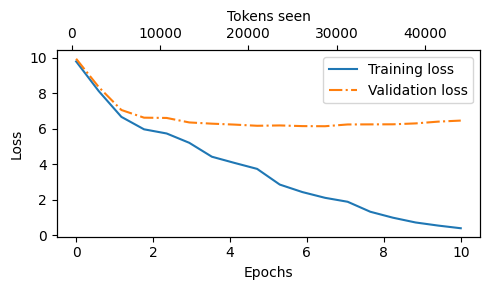

In [23]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, token_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5,3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")

    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(token_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, token_seen, train_losses, val_losses)

In [ ]:
torch.save({"model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict()},
          )